# Import Required Libraries
Import necessary libraries such as pandas, numpy, scipy, and matplotlib.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from geopy.distance import geodesic

# Load and Display CSV Data
Load the accelerometer, orientation, and location data from CSV files and display the first few rows of each DataFrame.

In [2]:
# Load and Display CSV Data
# Load the CSV files
accel_df = pd.read_csv('accelerometer.csv', sep=',')
orient_df = pd.read_csv('orientation.csv', sep=',')
location_df = pd.read_csv('location.csv', sep=',')

# Display the loaded DataFrames
print("Accelerometer DataFrame:")
print(accel_df.head())

print("\nOrientation DataFrame:")
print(orient_df.head())

print("\nLocation DataFrame:")
print(location_df.head())

# Merge the data from the three CSVs based on time
merged_df = pd.merge_asof(accel_df.sort_values('time'), orient_df.sort_values('time'), on='time', direction='nearest')
merged_df = pd.merge_asof(merged_df.sort_values('time'), location_df.sort_values('time'), on='time', direction='nearest')

merged_df.head()

Accelerometer DataFrame:
                  time  seconds_elapsed         z         y         x
0  1728905892151481300         0.124481  3.031113  1.739928 -2.738261
1  1728905892161481200         0.134481  2.543669  2.172559 -2.676702
2  1728905892171481300         0.144481  0.708398  1.350286 -2.833233
3  1728905892181481200         0.154481 -0.942148  0.140309 -2.983238
4  1728905892191481300         0.164481 -2.296083 -0.994283 -3.362856

Orientation DataFrame:
                  time  seconds_elapsed        qz        qy        qx  \
0  1728905892151481300         0.124481  0.405595  0.021519  0.182252   
1  1728905892161481200         0.134481  0.408554  0.012109  0.184250   
2  1728905892171481300         0.144481  0.413500  0.005160  0.188648   
3  1728905892181481200         0.154481  0.419639  0.000997  0.195267   
4  1728905892191481300         0.164481  0.426294 -0.001826  0.204571   

         qw      roll     pitch       yaw  
0  0.895440 -0.116665 -0.351011 -0.871329  
1  0

,time,seconds_elapsed_x,z,y,x,seconds_elapsed_y,qz,qy,qx,qw,...,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,1728905892151481300,0.124481,3.031113,1.739928,-2.738261,0.124481,0.405595,0.021519,0.182252,0.895440,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
1,1728905892161481200,0.134481,2.543669,2.172559,-2.676702,0.134481,0.408554,0.012109,0.184250,0.893861,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
2,1728905892171481300,0.144481,0.708398,1.350286,-2.833233,0.144481,0.413500,0.005160,0.188648,0.890731,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
3,1728905892181481200,0.154481,-0.942148,0.140309,-2.983238,0.154481,0.419639,0.000997,0.195267,0.886437,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
4,1728905892191481300,0.164481,-2.296083,-0.994283,-3.362856,0.164481,0.426294,-0.001826,0.204571,0.881146,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805


# Merge DataFrames
Merge the accelerometer, orientation, and location DataFrames based on the time column using the nearest method.

In [3]:
# Merge DataFrames
# Merge the data from the three CSVs based on time using the nearest method
merged_df = pd.merge_asof(accel_df.sort_values('time'), orient_df.sort_values('time'), on='time', direction='nearest')
merged_df = pd.merge_asof(merged_df.sort_values('time'), location_df.sort_values('time'), on='time', direction='nearest')

# Display the merged DataFrame
merged_df.head()

,time,seconds_elapsed_x,z,y,x,seconds_elapsed_y,qz,qy,qx,qw,...,seconds_elapsed,bearingAccuracy,speedAccuracy,verticalAccuracy,horizontalAccuracy,speed,bearing,altitude,longitude,latitude
0,1728905892151481300,0.124481,3.031113,1.739928,-2.738261,0.124481,0.405595,0.021519,0.182252,0.895440,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
1,1728905892161481200,0.134481,2.543669,2.172559,-2.676702,0.134481,0.408554,0.012109,0.184250,0.893861,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
2,1728905892171481300,0.144481,0.708398,1.350286,-2.833233,0.144481,0.413500,0.005160,0.188648,0.890731,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
3,1728905892181481200,0.154481,-0.942148,0.140309,-2.983238,0.154481,0.419639,0.000997,0.195267,0.886437,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805
4,1728905892191481300,0.164481,-2.296083,-0.994283,-3.362856,0.164481,0.426294,-0.001826,0.204571,0.881146,...,1.439,45.0,1.5,1.099718,17.941,0.0,0.0,74.099998,-0.607808,44.79805


# Implement High-Pass Filter
Define a function to implement a high-pass filter using scipy's signal processing functions.

In [6]:
# Implement High-Pass Filter
def high_pass_filter(data, cutoff_frequency, sampling_rate):
    """
    Apply a high-pass filter to the data.
    
    Parameters:
    - data: The input signal data to be filtered.
    - cutoff_frequency: The cutoff frequency of the high-pass filter.
    - sampling_rate: The sampling rate of the data.
    
    Returns:
    - filtered_data: The filtered signal data.
    """
    # Normalize the cutoff frequency with the Nyquist frequency
    nyquist_frequency = 0.5 * sampling_rate
    normalized_cutoff = cutoff_frequency / nyquist_frequency
    
    # Design the high-pass filter
    b, a = butter(N=1, Wn=normalized_cutoff, btype='high', analog=False)
    
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

# Apply the high-pass filter to the Z-axis acceleration data
sampling_rate = 100  # Example sampling rate in Hz, adjust as needed
cutoff_frequency = 0.1  # Example cutoff frequency in Hz, adjust as needed

merged_df['filtered_z'] = high_pass_filter(merged_df['z'], cutoff_frequency, sampling_rate)

# Display the first few rows of the DataFrame with the filtered data
merged_df.head()



def get_color_from_shock(z_value, min_z, max_z):
    norm = mcolors.Normalize(vmin=min_z, vmax=max_z)
    cmap = plt.get_cmap('RdYlGn_r')  # Gradient de rouge à vert inversé
    rgba = cmap(norm(z_value))
    return mcolors.to_hex(rgba)

# Detect Shocks with Filtered Data
Use the filtered accelerometer data to detect shocks based on a specified threshold.

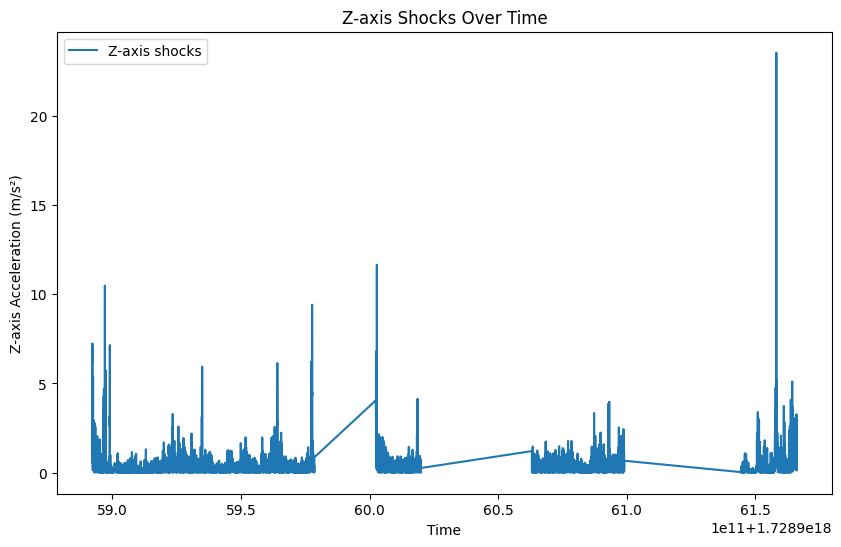

In [14]:
# Detect Shocks with Filtered Data

# Function to convert quaternions to rotation matrix
def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    return R.from_quat([qx, qy, qz, qw])

# Apply the rotation to get acceleration in the global frame
def rotate_acceleration(accel_x, accel_y, accel_z, rotation):
    accel_local = np.array([accel_x, accel_y, accel_z])
    accel_global = rotation.apply(accel_local)
    return accel_global

# List to store results
results = []

# Parameter to detect vertical shocks (only on the Z-axis)
shock_threshold = 3  # adjustable shock detection threshold

# Lists to store times and Z-axis shocks
times = []
z_shocks = []

# Iterate through each row in the merged DataFrame
for _, row in merged_df.iterrows():
    # Retrieve acceleration and orientation values
    accel_z = row['filtered_z']  # Use filtered Z-axis acceleration
    qw, qx, qy, qz = row['qw'], row['qx'], row['qy'], row['qz']
    
    # Get the rotation matrix from quaternions
    rotation = quaternion_to_rotation_matrix(qw, qx, qy, qz)
    
    # Apply the rotation to the Z-axis acceleration
    accel_global = rotate_acceleration(0, 0, accel_z, rotation)
    
    # Get the Z component in the global frame
    z_global = accel_global[2]
    
    # Add the value to the times and shocks lists
    times.append(row['time'])
    z_shocks.append(abs(z_global))
    
    # Detect a shock if the Z component exceeds the threshold
    if abs(z_global) > shock_threshold:
        results.append((row['time'], abs(z_global), row['latitude'], row['longitude']))

# If shocks are detected, display them on a map
m = folium.Map(location=[location_df['latitude'].iloc[0], location_df['longitude'].iloc[0]], zoom_start=15)

# Draw the trajectory on the map with a line
trajectory = list(zip(location_df['latitude'], location_df['longitude']))
folium.PolyLine(trajectory, color='blue', weight=2.5, opacity=0.7).add_to(m)

# Filter shocks to avoid redundancy (keep only one shock per 1 meter zone)
def distance_between_coords(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

if results:
    shock_df = pd.DataFrame(results, columns=['time', 'z_global', 'latitude', 'longitude'])
    
    # Find the min and max shock values to normalize colors
    min_z = shock_df['z_global'].min()
    max_z = shock_df['z_global'].max()

    filtered_shocks = []  # List to store non-redundant shocks

    # Iterate through detected shocks and filter those too close
    for i, row in shock_df.iterrows():
        lat, lon, z_global = row['latitude'], row['longitude'], row['z_global']
        
        too_close = False
        for j, shock in enumerate(filtered_shocks):
            lat2, lon2, z_global2 = shock[2], shock[3], shock[1]
            if distance_between_coords(lat, lon, lat2, lon2) < 1:
                too_close = True
                # If a shock is already close, keep the one with the greatest intensity
                if z_global > z_global2:
                    filtered_shocks[j] = (row['time'], z_global, lat, lon)
                break
        
        if not too_close:
            filtered_shocks.append((row['time'], z_global, lat, lon))

    # Add filtered shock points to the map with a color gradient
    for shock in filtered_shocks:
        time, z_global, lat, lon = shock
        shock_color = get_color_from_shock(z_global, min_z, max_z)
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            popup=f"Shock detected at {time} with an acceleration of {z_global:.2f} m/s²",
            color=shock_color,
            fill=True,
            fill_opacity=0.7
        ).add_to(m)

# Display the Z-axis shocks over time
plt.figure(figsize=(10, 6))
plt.plot(times, z_shocks, label='Z-axis shocks')
plt.xlabel('Time')
plt.ylabel('Z-axis Acceleration (m/s²)')
plt.title('Z-axis Shocks Over Time')
plt.legend()
plt.show()

# Display the map
m